In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

In [2]:
df = sns.load_dataset('tips')
df['percent_tip'] = df['tip'] / df['total_bill'] * 100
df = pd.concat([df, df.assign(sex='Both')])
ds = df.to_xarray().set_coords('sex')

In [3]:
def calc_bootstrap(data, bootstrap_index):
    # https://github.com/rougier/numpy-100/blob/master/
    # 100_Numpy_exercises_with_hints_with_solutions.md
    # #100-compute-bootstrapped-95-confidence-intervals-
    # for-the-mean-of-a-1d-array-x-ie-resample-the-
    # elements-of-an-array-with-replacement-n-times-
    # compute-the-mean-of-each-sample-and-
    # then-compute-percentiles-over-the-means-
    return data.squeeze(axis=-1)[bootstrap_index]


def calc_bootstrap_means(da, iterations=1000):
    index = xr.DataArray(
        np.random.randint(0, len(da), (iterations, len(da))),
        coords={'index': da['index'], 'sample': range(iterations)},
        dims=['sample', 'index']
    )
    return xr.apply_ufunc(calc_bootstrap, da, index).mean('index')

In [4]:
sample_mean = ds['percent_tip'].groupby('sex').mean()
sample_std = ds['percent_tip'].groupby('sex').std()
bootstrap_means = {
    sex: calc_bootstrap_means(ds['percent_tip']).values
    for sex in np.unique(ds['sex'])
}
standard_err = {
    sex: bs_mean.std()
    for sex, bs_mean
    in bootstrap_means.items()
}
lower_confidence_interval_err = {
    sex: bs_mean.mean() - np.percentile(bs_mean, 2.5)
    for sex, bs_mean
    in bootstrap_means.items()
}
upper_confidence_interval_err = {
    sex: np.percentile(bs_mean, 97.5) - bs_mean.mean()
    for sex, bs_mean
    in bootstrap_means.items()
}

In [5]:
stat_df = pd.concat([
    pd.Series(sample_mean, index=sample_mean['sex'], name='sample_mean'),
    pd.Series(sample_std, index=sample_mean['sex'], name='sample_std'),
    pd.Series(standard_err, name='standard_err'),
    pd.Series(lower_confidence_interval_err, 
              name='lower_confidence_interval_err'),
    pd.Series(upper_confidence_interval_err,
              name='upper_confidence_interval_err')
], axis=1).reset_index()

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

Text(0, 0.5, 'Tip Percent of Total Bill')

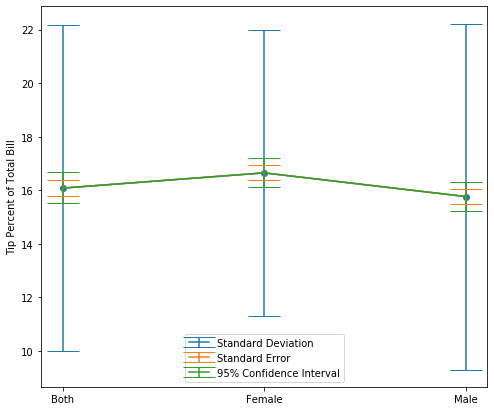

In [6]:
fig = plt.figure(figsize=(8, 7))
ax = plt.axes()
ax.scatter(stat_df['sex'], stat_df['sample_mean'])
ax.errorbar(stat_df['sex'], stat_df['sample_mean'],
            yerr=stat_df['sample_std'], capsize=16,
            label='Standard Deviation')
ax.errorbar(stat_df['sex'], stat_df['sample_mean'],
            yerr=stat_df['standard_err'], capsize=16, label='Standard Error')
ax.errorbar(stat_df['sex'], stat_df['sample_mean'],
            yerr=[stat_df['lower_confidence_interval_err'],
                  stat_df['upper_confidence_interval_err']], capsize=16,
            label='95% Confidence Interval')
ax.set_ylabel('Tip Percent of Total Bill')
ax.legend()

In [7]:
t, p_two_tailed = stats.ttest_ind(
    bootstrap_means['Male'], bootstrap_means['Female'])
print(f'Because the p-value ({p_two_tailed:.2f}) is greater than 0.05, '
      f'there is no statistically significant difference of tipping '
      f'between Males and Females')

Because the p-value (0.69) is greater than 0.05, there is no statistically significant difference of tipping between Males and Females
